# 01 Clean and Resample SOS Data
### Author: Danny Hogan and Eli Schwat
### Date: Maty 6, 2024

This notebook will clean the SOS eddy covariance data a few different ways and then resample the dataset from 5-minute averages to 1-hour, 3-hour, 6-hour, 12-hour, and 1-day averages/medians/sums. These datasets will then be saved as analysis products.

### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
import time
from tqdm import tqdm
from joblib import Parallel, delayed

# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, mean_sounding, simple_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

nctoolkit is using Climate Data Operators version 2.3.0


## 1. Load SOS data
We'll begin by loading up the SOS data and 

In [3]:
# set up the data directory
DATE_FORMAT_STR = '%Y%m%d'
start_date = '20221130'
# end_date = '20230509'
end_date = '20230619'
PLANAR_FIT = False

datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()
print(datelist)

['20221130', '20221201', '20221202', '20221203', '20221204', '20221205', '20221206', '20221207', '20221208', '20221209', '20221210', '20221211', '20221212', '20221213', '20221214', '20221215', '20221216', '20221217', '20221218', '20221219', '20221220', '20221221', '20221222', '20221223', '20221224', '20221225', '20221226', '20221227', '20221228', '20221229', '20221230', '20221231', '20230101', '20230102', '20230103', '20230104', '20230105', '20230106', '20230107', '20230108', '20230109', '20230110', '20230111', '20230112', '20230113', '20230114', '20230115', '20230116', '20230117', '20230118', '20230119', '20230120', '20230121', '20230122', '20230123', '20230124', '20230125', '20230126', '20230127', '20230128', '20230129', '20230130', '20230131', '20230201', '20230202', '20230203', '20230204', '20230205', '20230206', '20230207', '20230208', '20230209', '20230210', '20230211', '20230212', '20230213', '20230214', '20230215', '20230216', '20230217', '20230218', '20230219', '20230220', '20

Variable names below:

In [4]:
# Separate out the eddy covariance measurement variable names because they are very repetitive
ec_measurement_suffixes = [
    '1m_ue',    '2m_ue',    '3m_ue',    '10m_ue', 
    '1m_d',     '2m_d',     '3m_d',     '10m_d',
    '1m_uw',    '2m_uw',    '2_5m_uw',  '3m_uw',    '10m_uw', 
    '1m_c',     '2m_c',     '3m_c',     '5m_c',     '10m_c',    '15m_c',    '20m_c'
]

sonic_measurement_prefixes = [
    'u_', 'v_', 'w_', 'tc_', 'spd_', 'dir_', 
    'u_u__', 'v_v__', 'w_w__', 'tc_tc__', 
    'u_w__', 'v_w__', 'u_v__', 
    'u_tc__', 'v_tc__', 'w_tc__', 
    'u_u_u__', 'v_v_v__', 'w_w_w__', 
    'tc_tc_tc__', 
]
irga_measurement_prefixes = [
    'h2o_', 'h2o_h2o__', 'h2o_h2o_h2o__', 
]
sonic_plus_irga_measurement_prefixes = [
    'u_h2o__', 'v_h2o__', 'w_h2o__', 
]
ec_measurement_prefixes = sonic_measurement_prefixes + irga_measurement_prefixes + sonic_plus_irga_measurement_prefixes

ec_variable_names = [
    (prefix + suffix) for prefix in ec_measurement_prefixes for suffix in ec_measurement_suffixes
]

counts_vars = ['counts_' + suffix for suffix in ec_measurement_suffixes]
counts_1_vars = ['counts_' + suffix + '_1' for suffix in ec_measurement_suffixes]
counts_2_vars = ['counts_' + suffix + '_2' for suffix in ec_measurement_suffixes]
irgadiag_vars = ['irgadiag_' + suffix for suffix in ec_measurement_suffixes]
ldiag_vars = ['ldiag_' + suffix for suffix in ec_measurement_suffixes]

diagnostic_variable_names = counts_vars + counts_1_vars + counts_2_vars + irgadiag_vars + ldiag_vars

VARIABLE_NAMES = ec_variable_names + diagnostic_variable_names + [
    # Temperature & Relative Humidity Array 
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward/Upward Facing Longwave Radiometers
    'Rpile_out_9m_d','Tcase_out_9m_d',    
    'Rpile_in_9m_d', 'Tcase_in_9m_d',
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d', 'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',

    # Ground Heat Flux
    'Gsoil_d',
    
    # Soil Temperature
    'Tsoil_0_6cm_d','Tsoil_3_1cm_d','Tsoil_1_9cm_d','Tsoil_4_4cm_d','Tsoil_8_1cm_d','Tsoil_9_4cm_d','Tsoil_10_6cm_d','Tsoil_11_9cm_d','Tsoil_18_1cm_d',
    'Tsoil_19_4cm_d','Tsoil_20_6cm_d','Tsoil_21_9cm_d','Tsoil_28_1cm_d','Tsoil_29_4cm_d','Tsoil_30_6cm_d','Tsoil_31_9cm_d'
    ]

#### Let's begin by downloading the SOS data and storing it in the /storage/ directory

In [5]:
# Let's begin by downloading the SOS data and storing it in the /storage/ directory
output_dir = '/storage/dlhogan/synoptic_sublimation/sos_data/sosqc/v2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if 'sosnoqc' in output_dir:
    print("Downloading no qc data")
    sos_5min_ds = utils.download_sos_data(
                            start_date=start_date,
                            end_date=end_date,
                            variable_names=VARIABLE_NAMES,
                            local_download_dir=output_dir,
                            cache=True
                        );  
else:
    if not os.path.exists("../../01_data/raw_data/sos_ds_all_storage_20240506.nc"):
        print("Creating qc'd data file...")
        start = time.time()
        all_file_paths = [
        os.path.join(
            output_dir,
            f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
        ) for date in datelist
        ]
        datasets = []
        for i,file in enumerate(all_file_paths):
            ds = xr.open_dataset(file)
            # this ensures we don't access variables that aren't in this dataset, which would throw an error
            ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)] # variables.DEFAULT_VARIABLES+hf.WATER_VAPOR_VARIABLES+hf.COUNT_VARIABLES
            datasets.append(ds_new)
            # for every 10th file, print the time between
            if i % 10 == 0:
                print(f"Time elapsed for 10 files: {time.time()-start}")
                start = time.time()
        sos_ds = xr.concat(datasets, dim='time')
        # ensure time index is evernly spaced by filling in missing times
        sos_ds = utils.fill_missing_timestamps(sos_ds)
        sos_ds.to_netcdf("../../01_data/raw_data/sos_ds_all_storage_20240506.nc")
    else:
        print("Loading qc'd data file...")
        sos_ds = xr.open_dataset("../../01_data/raw_data/sos_ds_all_storage_20240506.nc")

Loading qc'd data file...


### We'll now replace the sonic anemometer and IRGAson flags with [Eli's calculations](https://github.com/elischwat/sublimationofsnow/blob/master/analysis/paper1/highrate_data_count_bad_data.py)

In [6]:
flag_counts_df = pd.read_parquet("../../01_data/raw_data/sosqc_fast_flagcounts/").loc[start_date: end_date]
assert all(sos_ds.time == flag_counts_df.index)

In [7]:
irga_vars = [
    'irgadiag_10m_c',	 'irgadiag_10m_d',	 'irgadiag_10m_ue',	 'irgadiag_10m_uw',	 'irgadiag_15m_c',	 'irgadiag_1m_c',	 'irgadiag_1m_d',	 'irgadiag_1m_ue',	 
    'irgadiag_1m_uw',	 'irgadiag_20m_c',	 'irgadiag_2m_c',	 'irgadiag_3m_c',	 'irgadiag_3m_d',	 'irgadiag_3m_ue',	 'irgadiag_3m_uw',	 'irgadiag_5m_c',	
]

ldiag_vars = [
    'ldiag_10m_c', 'ldiag_10m_d', 'ldiag_10m_ue', 'ldiag_10m_uw', 'ldiag_15m_c', 'ldiag_1m_c', 'ldiag_1m_d', 'ldiag_1m_ue', 
    'ldiag_1m_uw', 'ldiag_20m_c', 'ldiag_2m_c', 'ldiag_3m_c', 'ldiag_3m_d', 'ldiag_3m_ue', 'ldiag_3m_uw', 'ldiag_5m_c',
]

for var in irga_vars + ldiag_vars:
    sos_ds[var] = flag_counts_df[var]

## Now we will begin the process of resampling

### First, we separate which variables need to be reynolds averaged, median, averaged, and summed
All EC variables will be reynolds averaged up to 1-hour. From there, all other resampling will be built off of the 1-hour Reynold's averaged values. All normal met variables, except wind direction will be averaged. Wind direction will be median. This will eventually be replaced with the average 

In [8]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_h2o__1m_uw',  'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_h2o__1m_uw',
        'u_u__2m_uw',    'v_v__2m_uw',    'w_w__2m_uw',    'u_w__2m_uw',    'v_w__2m_uw',  'u_tc__2m_uw',  'v_tc__2m_uw',   'u_h2o__2m_uw',  'v_h2o__2m_uw',   'w_tc__2m_uw',   'w_h2o__2m_uw',
        'u_u__2_5m_uw', 'v_v__2_5m_uw',   'w_w__2_5m_uw',  'u_w__2_5m_uw',  'v_w__2_5m_uw','u_tc__2_5m_uw','v_tc__2_5m_uw', 'u_h2o__2_5m_uw','v_h2o__2_5m_uw', 'w_tc__2_5m_uw', 'w_h2o__2_5m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_h2o__3m_uw',  'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_h2o__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_h2o__1m_ue',  'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_h2o__1m_ue',
        'u_u__2m_ue',    'v_v__2m_ue',    'w_w__2m_ue',    'u_w__2m_ue',    'v_w__2m_ue',  'u_tc__2m_ue',  'v_tc__2m_ue',   'u_h2o__2m_ue',  'v_h2o__2m_ue',   'w_tc__2m_ue',   'w_h2o__2m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_h2o__3m_ue',  'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_h2o__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_h2o__1m_d',   'v_h2o__1m_d',    'w_tc__1m_d',    'w_h2o__1m_d',
        'u_u__2m_d',     'v_v__2m_d',     'w_w__2m_d',     'u_w__2m_d',     'v_w__2m_d',   'u_tc__2m_d',   'v_tc__2m_d',    'u_h2o__2m_d',   'v_h2o__2m_d',    'w_tc__2m_d',    'w_h2o__2m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_h2o__3m_d',   'v_h2o__3m_d',    'w_tc__3m_d',    'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_h2o__10m_d',  'v_h2o__10m_d',   'w_tc__10m_d',   'w_h2o__10m_d',
        'u_u__1m_c',     'v_v__1m_c',     'w_w__1m_c',     'u_w__1m_c',     'v_w__1m_c',   'u_tc__1m_c',   'v_tc__1m_c',    'u_h2o__1m_c',   'v_h2o__1m_c',    'w_tc__1m_c',    'w_h2o__1m_c',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_h2o__2m_c',   'v_h2o__2m_c',    'w_tc__2m_c',    'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_h2o__3m_c',   'v_h2o__3m_c',    'w_tc__3m_c',    'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_h2o__5m_c',   'v_h2o__5m_c',    'w_tc__5m_c',    'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_h2o__10m_c',  'v_h2o__10m_c',   'w_tc__10m_c',   'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_h2o__15m_c',  'v_h2o__15m_c',   'w_tc__15m_c',   'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_h2o__20m_c',  'v_h2o__20m_c',   'w_tc__20m_c',   'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensors
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',

        # Soil Moisture
        # 'Gsoil_d',
        
        # Diagnostic variables for irga and sonic
        'irgadiag_1m_c',    'ldiag_1m_c',
        'irgadiag_2m_c',    'ldiag_2m_c',
        'irgadiag_3m_c',    'ldiag_3m_c',
        'irgadiag_5m_c',    'ldiag_5m_c',
        'irgadiag_10m_c',   'ldiag_10m_c',
        'irgadiag_15m_c',   'ldiag_15m_c',
        'irgadiag_20m_c',   'ldiag_20m_c',
        'irgadiag_1m_uw',   'ldiag_1m_uw',
        'irgadiag_3m_uw',   'ldiag_3m_uw',
        'irgadiag_10m_uw',  'ldiag_10m_uw',
        'irgadiag_1m_ue',   'ldiag_1m_ue',
        'irgadiag_3m_ue',   'ldiag_3m_ue',
        'irgadiag_10m_ue',  'ldiag_10m_ue',
        'irgadiag_1m_d',    'ldiag_1m_d',
        'irgadiag_3m_d',    'ldiag_3m_d',
        'irgadiag_10m_d',   'ldiag_10m_d',

    ],
    'median' : [
        'dir_1m_uw',    
        'dir_3m_uw',    
        'dir_10m_uw',   
        'dir_1m_ue',    
        'dir_3m_ue',    
        'dir_10m_ue',   
        'dir_1m_d',     
        'dir_3m_d',     
        'dir_10m_d',    
        'dir_2m_c',     
        'dir_3m_c',     
        'dir_5m_c',     
        'dir_10m_c',    
        'dir_15m_c',    
        'dir_20m_c',    
    ],
    'sum' : [
        # Counts of unflagged instantaneous (20hz) eddy covariance measurements
        # momentum flux flags   LHFlux flags   SH flux flags       
        'counts_1m_c',    'counts_1m_c_1',    'counts_1m_c_2',    
        'counts_2m_c',    'counts_2m_c_1',    'counts_2m_c_2',    
        'counts_3m_c',    'counts_3m_c_1',    'counts_3m_c_2',    
        'counts_5m_c',    'counts_5m_c_1',    'counts_5m_c_2',    
        'counts_10m_c',   'counts_10m_c_1',   'counts_10m_c_2',   
        'counts_15m_c',   'counts_15m_c_1',   'counts_15m_c_2',   
        'counts_20m_c',   'counts_20m_c_1',   'counts_20m_c_2',   
        'counts_1m_uw',   'counts_1m_uw_1',   'counts_1m_uw_2',   
        'counts_3m_uw',   'counts_3m_uw_1',   'counts_3m_uw_2',   
        'counts_10m_uw',  'counts_10m_uw_1',  'counts_10m_uw_2',  
        'counts_1m_ue',   'counts_1m_ue_1',   'counts_1m_ue_2',   
        'counts_3m_ue',   'counts_3m_ue_1',   'counts_3m_ue_2',   
        'counts_10m_ue',  'counts_10m_ue_1',  'counts_10m_ue_2',  
        'counts_1m_d',    'counts_1m_d_1',    'counts_1m_d_2',    
        'counts_3m_d',    'counts_3m_d_1',    'counts_3m_d_2',    
        'counts_10m_d',   'counts_10m_d_1',   'counts_10m_d_2',   
    ]
}

### Next, we remove instrument-flagged data
Based on Stiperski and Rotach (2016, http://link.springer.com/10.1007/s10546-015-0103-z), who recommend the following steps as minimum quality criteria:

The sonic diagnostic flag was set high (malfunctioning of the instrument) inside the averaging period.
KH20 voltage fell below 5 mV (indication of condensation occurring on the KH20 window).
Skewness of temperature and wind components fell outside the [-2, 2] range, following Vickers and Mahrt (1997).
Kurtosis of temperature and wind components was >8, following Vickers and Mahrt (1997).


Here, we only implement number #2 and #3. We tried implementing #1, using the ldiag flag to remove sonic data, but it removed a lot of data, and, without using high rate data, we't cannot filter based on a "high" diagnostic flag, we can only filtering using the aggregate of all the flags (i.e. ldiag > 0). The 4th moments are not included in the 5-minute averages, so we cannot implement #4 without using the high rate data.

### Set bad Irga measurements to NaN
The NCAR report recommends all Irga-related measurements be set to NaN when irgadiag is non-zero. They did this for some but not all of the data.

In [9]:
print('h2o_flux_var', 'irgadiag_var', 'old_nan_count_badirga', 'new_nan_count_badirga', 'old_mean', 'new_mean')
var_ls = []
old_nan_count_badirga_ls = []
new_nan_count_badirga_ls = []
old_mean_ls = []
new_mean_ls = []
old_median_ls = []
new_median_ls = []
for suffix in ec_measurement_suffixes:
    h2o_flux_var = 'w_h2o__' + suffix
    irgadiag_var = 'irgadiag_' + suffix
     
    old_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    old_mean = sos_ds[h2o_flux_var].mean().item()
    old_median = sos_ds[h2o_flux_var].median().item()

    # Here, we gather 75% of valid measurements in each 5-minute window
    for prefix in ec_measurement_prefixes:
        var = prefix + suffix
        if var in sos_ds:
            sos_ds[var] = sos_ds[var].where(sos_ds[irgadiag_var] <= 1500)
    # for prefix in [
    #     'h2o_', 'h2o_h2o__', 'u_h2o__', 'v_h2o__', 'w_h2o__',
    #     # I'M NOT SURE I WANT TO REMOVE THESE w_ MEASUREMENTS BUT I"M CURIOUS WHAT HAPPENS IF I DO
    #     'w_',
    # ]:


    new_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    new_mean = sos_ds[h2o_flux_var].mean().item()
    new_median = sos_ds[h2o_flux_var].median().item()
    print(h2o_flux_var, irgadiag_var, old_nan_count_badirga, new_nan_count_badirga, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_badirga_ls.append(old_nan_count_badirga)
    new_nan_count_badirga_ls.append(new_nan_count_badirga)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)
    old_median_ls.append(old_median)
    new_median_ls.append(new_median)

h2o_flux_var irgadiag_var old_nan_count_badirga new_nan_count_badirga old_mean new_mean
w_h2o__1m_ue irgadiag_1m_ue 41689 41727 0.013064 0.013078
w_h2o__2m_ue irgadiag_2m_ue 26927 27086 0.003893 0.003921
w_h2o__3m_ue irgadiag_3m_ue 6257 6379 0.007387 0.007375
w_h2o__10m_ue irgadiag_10m_ue 5396 5492 0.006937 0.006951
w_h2o__1m_d irgadiag_1m_d 40716 40750 0.011762 0.011818
w_h2o__2m_d irgadiag_2m_d 28280 28418 0.003448 0.003476
w_h2o__3m_d irgadiag_3m_d 6508 6659 0.007451 0.007495
w_h2o__10m_d irgadiag_10m_d 6099 6218 0.007046 0.00708
w_h2o__1m_uw irgadiag_1m_uw 45595 45613 0.016544 0.016536
w_h2o__2m_uw irgadiag_2m_uw 34420 34455 0.003301 0.003314
w_h2o__2_5m_uw irgadiag_2_5m_uw 49617 49659 0.00223 0.002221
w_h2o__3m_uw irgadiag_3m_uw 5550 5642 0.007506 0.007517
w_h2o__10m_uw irgadiag_10m_uw 6966 7105 0.00708 0.007134
w_h2o__1m_c irgadiag_1m_c 28791 28872 0.008771 0.008792
w_h2o__2m_c irgadiag_2m_c 4250 4360 0.006968 0.006989
w_h2o__3m_c irgadiag_3m_c 4309 4394 0.007235 0.007241
w_h2o__

Now, let's visualize what those changes did.

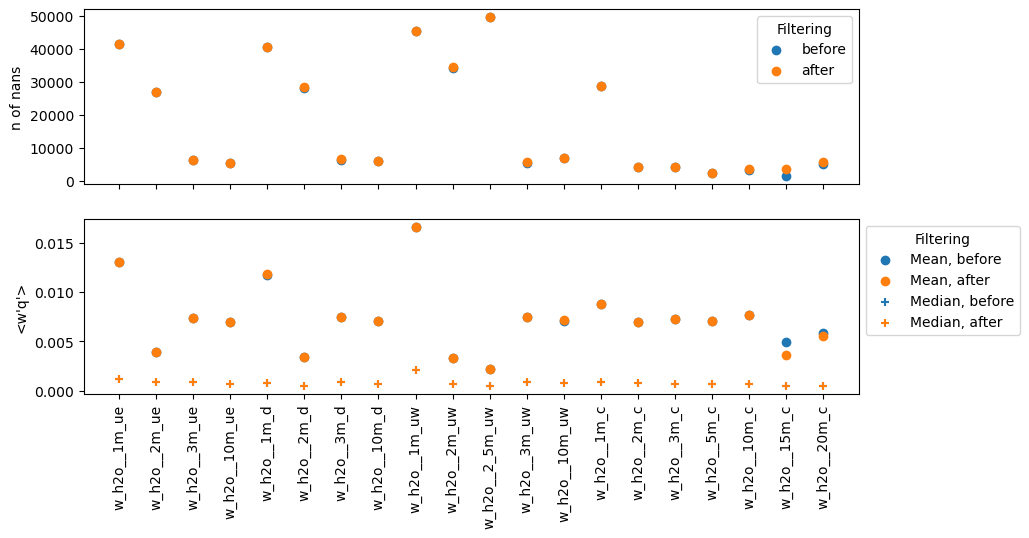

In [10]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badirga_ls, label = 'before', color='tab:blue')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badirga_ls, label = 'after', color='tab:orange')

axes[1].scatter(var_ls, old_mean_ls, label = 'Mean, before', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'Mean, after', color='tab:orange')

axes[1].scatter(var_ls, old_median_ls, label = 'Median, before', marker='+', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_median_ls, label = 'Median, after', marker='+', color='tab:orange')

for ax in axes:
    ax.tick_params(rotation=90, axis='x')
    ax.legend(title='Filtering', bbox_to_anchor=(1,1))

We see minimal changes accross the voard, except for a few locations which show some larger changes. These are locations generally with more nans. Median values remained relatively consistent after filtering while the mean values changed to a greater degree when filtering. 

### Set bad Sonic measurements to Nan

In [11]:
print('h2o_flux_var', 'ldiag_var', 'old_nan_count_badsonic', 'new_nan_count_badsonic', 'old_mean', 'new_mean')

var_ls = []
old_nan_count_badsonic_ls = []
new_nan_count_badsonic_ls = []
old_mean_ls = []
new_mean_ls = []
for suffix in ec_measurement_suffixes:
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    sonicdiag_var = 'ldiag_' + suffix
    old_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    old_mean = sos_ds[h2o_flux_var].mean().item()
    
    # sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(sos_ds[sonicdiag_var] == 0)
    # sos_ds[w_var] = sos_ds[w_var].where(sos_ds[sonicdiag_var] == 0)
    for prefix in ec_measurement_prefixes:
        var = prefix + suffix
        if var in sos_ds:
            sos_ds[var] = sos_ds[var].where(sos_ds[sonicdiag_var] <= 1500)

    new_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    new_mean = sos_ds[h2o_flux_var].mean().item()
    print(h2o_flux_var, sonicdiag_var, old_nan_count_badsonic, new_nan_count_badsonic, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_badsonic_ls.append(old_nan_count_badsonic)
    new_nan_count_badsonic_ls.append(new_nan_count_badsonic)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)

h2o_flux_var ldiag_var old_nan_count_badsonic new_nan_count_badsonic old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 41727 41865 0.013078 0.013119
w_h2o__2m_ue ldiag_2m_ue 27086 27086 0.003921 0.003921
w_h2o__3m_ue ldiag_3m_ue 6379 6591 0.007375 0.007333
w_h2o__10m_ue ldiag_10m_ue 5492 5651 0.006951 0.006908
w_h2o__1m_d ldiag_1m_d 40750 40974 0.011818 0.011806
w_h2o__2m_d ldiag_2m_d 28418 28418 0.003476 0.003476
w_h2o__3m_d ldiag_3m_d 6659 6830 0.007495 0.007451
w_h2o__10m_d ldiag_10m_d 6218 6319 0.00708 0.007046
w_h2o__1m_uw ldiag_1m_uw 45613 45816 0.016536 0.016692
w_h2o__2m_uw ldiag_2m_uw 34455 34455 0.003314 0.003314
w_h2o__2_5m_uw ldiag_2_5m_uw 49659 49659 0.002221 0.002221
w_h2o__3m_uw ldiag_3m_uw 5642 5829 0.007517 0.007456
w_h2o__10m_uw ldiag_10m_uw 7105 7180 0.007134 0.00709
w_h2o__1m_c ldiag_1m_c 28872 29053 0.008792 0.008788
w_h2o__2m_c ldiag_2m_c 4360 4540 0.006989 0.006942
w_h2o__3m_c ldiag_3m_c 4394 4681 0.007241 0.007211
w_h2o__5m_c ldiag_5m_c 2493 2724 0.007053 0.007043
w_h2

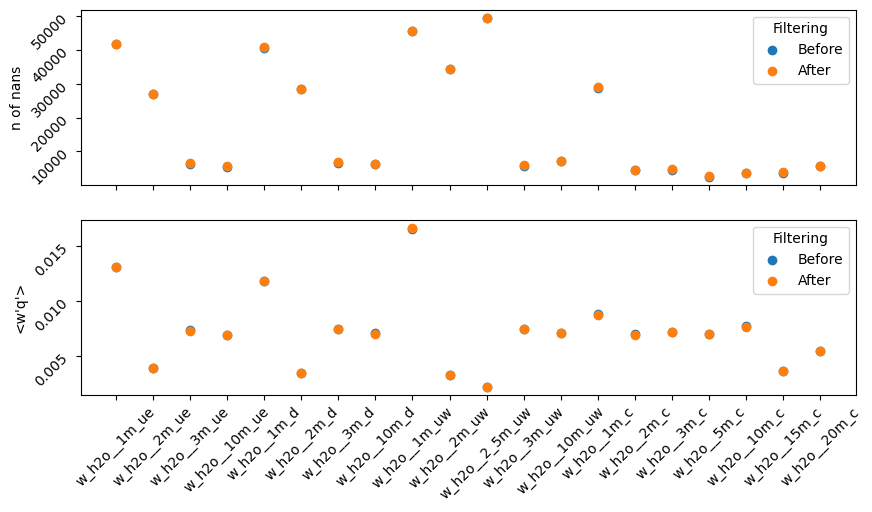

In [12]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badsonic_ls, label = 'Before')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badsonic_ls, label = 'After')

axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'After')

for ax in axes:
    ax.tick_params(rotation=45)
    ax.legend(title='Filtering')

### Interpolate missing EC variables up to 1 hour

In [13]:
print('h2o_flux_var', 'ldiag_var', 'old_nan_count_afterfilling', 'new_nan_count_afterfilling', 'old_mean', 'new_mean')

var_ls = []
old_nan_count_afterfilling_ls = []
new_nan_count_afterfilling_ls = []
old_mean_ls = []
new_mean_ls = []
for suffix in ec_measurement_suffixes:
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    sonicdiag_var = 'ldiag_' + suffix
    old_nan_count_afterfilling = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    old_mean = sos_ds[h2o_flux_var].mean().item()
    
    for prefix in ec_measurement_prefixes:
        var = prefix + suffix
        if var in sos_ds:
            sos_ds[var] = sos_ds[var].interpolate_na(dim='time', method='linear', limit=12)

    new_nan_count_afterfilling = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
    new_mean = sos_ds[h2o_flux_var].mean().item()
    print(h2o_flux_var, sonicdiag_var, old_nan_count_afterfilling, new_nan_count_afterfilling, round(old_mean,6), round(new_mean,6))
    var_ls.append(h2o_flux_var)
    old_nan_count_afterfilling_ls.append(old_nan_count_afterfilling)
    new_nan_count_afterfilling_ls.append(new_nan_count_afterfilling)
    old_mean_ls.append(old_mean)
    new_mean_ls.append(new_mean)

h2o_flux_var ldiag_var old_nan_count_afterfilling new_nan_count_afterfilling old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 41865 41189 0.013119 0.012677
w_h2o__2m_ue ldiag_2m_ue 27086 26254 0.003921 0.003897
w_h2o__3m_ue ldiag_3m_ue 6591 5023 0.007333 0.007197
w_h2o__10m_ue ldiag_10m_ue 5651 4164 0.006908 0.006753
w_h2o__1m_d ldiag_1m_d 40974 40644 0.011806 0.011797
w_h2o__2m_d ldiag_2m_d 28418 27853 0.003476 0.003385
w_h2o__3m_d ldiag_3m_d 6830 5201 0.007451 0.007254
w_h2o__10m_d ldiag_10m_d 6319 4696 0.007046 0.006969
w_h2o__1m_uw ldiag_1m_uw 45816 45339 0.016692 0.016185
w_h2o__2m_uw ldiag_2m_uw 34455 33766 0.003314 0.003249
w_h2o__2_5m_uw ldiag_2_5m_uw 49659 49376 0.002221 0.001943
w_h2o__3m_uw ldiag_3m_uw 5829 4454 0.007456 0.007321
w_h2o__10m_uw ldiag_10m_uw 7180 5471 0.00709 0.006966
w_h2o__1m_c ldiag_1m_c 29053 28261 0.008788 0.008657
w_h2o__2m_c ldiag_2m_c 4540 3576 0.006942 0.006891
w_h2o__3m_c ldiag_3m_c 4681 3635 0.007211 0.007163
w_h2o__5m_c ldiag_5m_c 2724 1984 0.007043 0.00

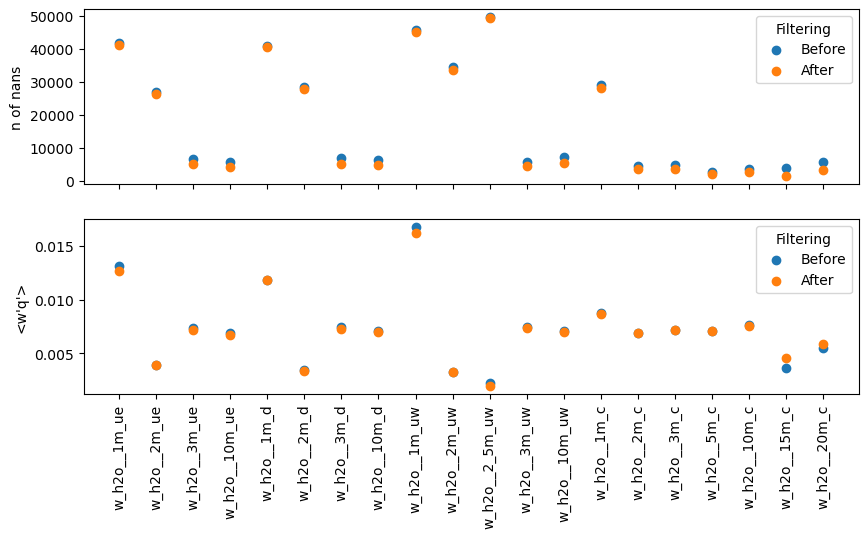

In [14]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_afterfilling_ls, label = 'Before')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_afterfilling_ls, label = 'After')

axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'After')

for ax in axes:
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Filtering')

Generally, this decreases the mean values and decreases number of nans.

### Now, let's summarize these changes

In [15]:
nan_counts_df = pd.DataFrame({
    'variable':                     var_ls,
    'n':                            len(sos_ds.time),
    'original nan count':           old_nan_count_badirga_ls, 
    'nans after bad irga removed':  new_nan_count_badirga_ls, 
    'nans after bad sonic removed': new_nan_count_badsonic_ls, 
    'nans after gap filling':       new_nan_count_afterfilling_ls,
})
limited_nan_counts_df = nan_counts_df[ 
    (~nan_counts_df.variable.str.contains('__1m_'))
    
    &
    (~nan_counts_df.variable.str.contains('__2_5m_'))
]
limited_nan_counts_df

,variable,n,original nan count,nans after bad irga removed,nans after bad sonic removed,nans after gap filling
1,w_h2o__2m_ue,58176,26927,27086,27086,26254
2,w_h2o__3m_ue,58176,6257,6379,6591,5023
3,w_h2o__10m_ue,58176,5396,5492,5651,4164
5,w_h2o__2m_d,58176,28280,28418,28418,27853
6,w_h2o__3m_d,58176,6508,6659,6830,5201
7,w_h2o__10m_d,58176,6099,6218,6319,4696
9,w_h2o__2m_uw,58176,34420,34455,34455,33766
11,w_h2o__3m_uw,58176,5550,5642,5829,4454
12,w_h2o__10m_uw,58176,6966,7105,7180,5471
14,w_h2o__2m_c,58176,4250,4360,4540,3576


### And we'll separate the reasons for these different flags. Note that the 1m sonics are removed.

In [16]:

limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic removed'] - limited_nan_counts_df['nans after bad irga removed']
limited_nan_counts_df[[
    'variable',
    'n',
    'Data removed by EC150 flag',
    'Data removed by CSAT3 flag'
]]

,variable,n,Data removed by EC150 flag,Data removed by CSAT3 flag
1,w_h2o__2m_ue,58176,159,0
2,w_h2o__3m_ue,58176,122,212
3,w_h2o__10m_ue,58176,96,159
5,w_h2o__2m_d,58176,138,0
6,w_h2o__3m_d,58176,151,171
7,w_h2o__10m_d,58176,119,101
9,w_h2o__2m_uw,58176,35,0
11,w_h2o__3m_uw,58176,92,187
12,w_h2o__10m_uw,58176,139,75
14,w_h2o__2m_c,58176,110,180


## Let's further clean the eddy-covariance data by removing bad values from the dataset.
Drop values outside of 5 standard deviations from the mean

In [17]:
def clean_covariance(ds, tower, height):
    # Written by Eli Schwat
    # print the mean before cleaning for the w_h2o__{height}m_{tower} variable
    print(f"mean before cleaning for w_h2o__{height}m_{tower}: {ds[f'w_h2o__{height}m_{tower}'].mean().values}")
    cleaned = turbulence.clean_eddy_covariance(
                                                ds[f'w_h2o__{height}m_{tower}'].values,
                                                ds[f'counts_{height}m_{tower}'].values,
                                                lower_threshold=np.nanmean(ds[f'w_h2o__{height}m_{tower}'].values)-(np.nanstd(ds[f'w_h2o__{height}m_{tower}'].values) * 5),
                                                upper_threshold=np.nanmean(ds[f'w_h2o__{height}m_{tower}'].values)+(np.nanstd(ds[f'w_h2o__{height}m_{tower}'].values) * 5),
                                            )
    # print the new cleaned mean
    print(f"mean after cleaning for w_h2o__{height}m_{tower}: {np.nanmean(cleaned)}")
    # add the cleaned data back into the dataset
    return cleaned

In [18]:
# get all variables that have _c in them
tower_c = [variable for variable in sos_ds if '_c' in variable]
# get all variables that have _d in them
tower_d = [variable for variable in sos_ds if '_d' in variable]
# get all variables that have _ue in them
tower_ue = [variable for variable in sos_ds if '_ue' in variable]
# get all variables that have _uw in them
tower_uw = [variable for variable in sos_ds if '_uw' in variable]

for tower in ['c', 'd', 'ue', 'uw']:
    for height in [1, 2, 3, 5, 10, 15, 20]:
        if (height in [2, 5, 10, 15, 20]):
            if (tower == 'c'):
                sos_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_ds, tower, height)
            elif height == 10:
                sos_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_ds, tower, height)
        else:
            if (height in [1, 3]) and (tower == 'c'):
                continue
            else:
                sos_ds[f'w_h2o__{height}m_{tower}'].values=clean_covariance(sos_ds, tower, height)


mean before cleaning for w_h2o__2m_c: 0.006891142576932907
mean after cleaning for w_h2o__2m_c: 0.005818466798120147
mean before cleaning for w_h2o__5m_c: 0.007038837764412165
mean after cleaning for w_h2o__5m_c: 0.005868720189079915
mean before cleaning for w_h2o__10m_c: 0.007559926714748144
mean after cleaning for w_h2o__10m_c: 0.006483437473555155
mean before cleaning for w_h2o__15m_c: 0.004571734461933374
mean after cleaning for w_h2o__15m_c: 0.004257747521401421
mean before cleaning for w_h2o__20m_c: 0.005853061564266682
mean after cleaning for w_h2o__20m_c: 0.005575561977826209
mean before cleaning for w_h2o__1m_d: 0.011797282844781876
mean after cleaning for w_h2o__1m_d: 0.011584840292396955
mean before cleaning for w_h2o__3m_d: 0.007253700401633978
mean after cleaning for w_h2o__3m_d: 0.0065729148544296885
mean before cleaning for w_h2o__10m_d: 0.006968729663640261
mean after cleaning for w_h2o__10m_d: 0.006186856242013521
mean before cleaning for w_h2o__1m_ue: 0.01267707906663

## Now, we have a clean, 5-minute dataset. From here we will resample the data

In [19]:
def separate_covariance_variable_name(cov_name):
    """Get the names of the two mean variables associated with a covariance variable. Built to use
    with SOS datasets. For example, one might provide `w_h2o__3m_c` and this function will return
    `w_3m_c` and `h2o_3m_c`.

    Args:
        cov_name (str): name of variable that you want to separate into the two names of the 
        asssociated mean variables.

    Returns:
        var1, var 2 (str, str): two strings with the names of the two mean variables
    """
    [first_parts, second_part] = cov_name.split('__')
    [var1, var2] = first_parts.split('_')
    [var1, var2] = [
        var1 +'_' + second_part,
        var2 +'_' + second_part,
    ]
    return var1, var2

def resample_moment(df, cov, mean1, mean2, new_frequency, n_in_new_re_length, skipna=True):
    """Combines moments into longer time periods, using reynolds averaging. Built to use with SOS 
    datasets. Resampling covariances which have been calculated for a specific Reynolds
    averaging length (e.g. the SOS datasets are averaged to 5minutes), you need both the mean
    values and covariance. For example, the variable `w_h2o__3m_c` is associated with mean values
    `w_3m_c` and `h2o_3m_c`. To reasmple `w_h2o__3m_c` to another averaging length, we need the three
    variables.

    Args:
        df (pd.Dataframe): Dataframe containing the three columns required for calculations (contains)
                    the names supplied as parameters `cov`, `mean1`, and `mean2`.
        cov (str): Name of covariance variable to resample using Reynolds averaing
        mean1 (str): Name of one of the two mean variables associated with `cov`
        mean2 (str): Name of the other mean variable associated with `cov`
        new_frequency (str): String interpretable by pandas/xarray that describes the reynolds length you 
            are resampling to. EG: '60Min'
        n_in_new_re_length (_type_): Number of 5 minute intervals that fit in the new_frequency. E.G. for
            new_frequency='60Min', you would provide 12.
        skipna (bool, optional): Whether to skip NaNs when calculating the new variables. Providing True
            will allow more moments to be calculated, but those moments may be inaccurate/non-representative.
            Providing False will result in more missing data.

    Returns:
        pd.DataFrame: Dataframe with resampled data.
    """
    return pd.DataFrame({
            cov: df.groupby(pd.Grouper(freq=new_frequency)).apply(
                lambda row: 
                    (1/n_in_new_re_length)*(row[cov] + row[mean1]*row[mean2]).sum(skipna=skipna)
                    - (
                        (1/n_in_new_re_length)*row[mean1].sum(skipna=skipna)
                        * (1/n_in_new_re_length)*row[mean2].sum(skipna=skipna)
                    )
            )
        })

def resample(ds, new_frequency, n_in_new_re_length, skipna=True):
    """Resample SOS xarray datasets, applying the proper aggregation function
    for different variables. Some are resampled by taking the mean, some by 
    summing, and others by Reynolds averaging. 
    """
    # Resample data vars that need to be averaged (plain old averaging)
    # Use built in xarray functionality
    resampled_averages = ds[
        data_vars_processing_dict['average']
    ].to_dataframe().resample(new_frequency).mean().to_xarray()

    resampled_medians = ds[
        data_vars_processing_dict['median']
    ].to_dataframe().resample(new_frequency).median().to_xarray()
    
    # Resample data vars that need to be summed
    # Use built in xarray functionality
    resampled_sums = ds[
        data_vars_processing_dict['sum']
    ].to_dataframe().resample(new_frequency).sum().to_xarray()
    
    # Resample data vars that need to be summed using the rules of Reynolds Averaging
    # Use our custom function defined above
    if n_in_new_re_length <= 24:
        resampled_reynolds_averages_list = []
        def split_covariance_name_and_resample(name):
            mean_var1, mean_var2 = separate_covariance_variable_name(name)
            resampled = resample_moment(
                ds[[mean_var1, mean_var2, name]].to_dataframe(), 
                name, 
                mean_var1, 
                mean_var2, 
                new_frequency, 
                n_in_new_re_length, 
                skipna=skipna
            )
            return resampled.to_xarray()
        resampled_reynolds_averages_list =  Parallel(n_jobs = 8)(
            delayed(split_covariance_name_and_resample)(name) 
            for name in tqdm(data_vars_processing_dict['reynolds_average'])
        )
    
        new_ds = xr.merge(
            [
                resampled_sums, 
                resampled_medians,
                resampled_averages
            ] + resampled_reynolds_averages_list
        )
    else:
            resampled_fluxes = ds[
                                data_vars_processing_dict['reynolds_average']
                                ].to_dataframe().resample(new_frequency).mean().to_xarray()
            new_ds = xr.merge([
                resampled_sums, 
                resampled_medians,
                resampled_averages,
                resampled_fluxes
            ] )

    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

Create and save these datasets

In [20]:
save_datasets = True
if save_datasets:
    sos_ds1H = resample(sos_ds, '60Min', 12, skipna=False)
    sos_ds3H = resample(sos_ds1H, '3H', 36, skipna=False)
    sos_ds6H = resample(sos_ds1H, '6H', 72, skipna=False)
    sos_ds12H = resample(sos_ds1H, '12H', 144, skipna=False)
    sos_ds1day = resample(sos_ds1H, '1D', 288, skipna=False)

    # save the 5 minute data
    sos_ds.to_netcdf("../../01_data/processed_data/sos_ds_5min_storage.nc")
    # save the 1 day data
    sos_ds1day.to_netcdf("../../01_data/processed_data/sos_ds_1day_storage.nc")
    # save the 60 minute data
    sos_ds1H.to_netcdf("../../01_data/processed_data/sos_ds_1H_storage.nc")
    # save the 3 hour data
    sos_ds3H.to_netcdf("../../01_data/processed_data/sos_ds_3H_storage.nc")
    # save the 12 hour data
    sos_ds12H.to_netcdf("../../01_data/processed_data/sos_ds_12H_storage.nc")
    # save the 6 hour data
    sos_ds6H.to_netcdf("../../01_data/processed_data/sos_ds_6H_storage.nc")

100%|██████████| 220/220 [02:21<00:00,  1.56it/s]
